# Predective Model for Recessions 

## Importing Modules

In [2]:
#Selenium Imports
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchWindowException, StaleElementReferenceException
#Threading library
import threading
#Data Manipulation Modules
import pandas as pd
from openpyxl import load_workbook
import re
from langdetect import detect, LangDetectException
#NLP and Sentiment Anlaysis Modules
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#Visualization Modules
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
#SkLearn modules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score
#FireBase
import firebase_admin
from firebase_admin import credentials, firestore, initialize_app
#Other Modules
from datetime import datetime, timedelta
import time
import numpy as np
import os
from dateutil.relativedelta import relativedelta
import validators


## Intialize Firebase


In [13]:
cred = credentials.Certificate("recession-predictive-model-firebase-adminsdk-6v7zc-df31e3a306.json")
initialize_app(cred)
fireDB = firestore.client()

def uploadToFirestore(dataframe, collection_name, max_batch_size=500):
    collectionRef = fireDB.collection(collection_name)
    batch = fireDB.batch()
    count = 0
    total_uploaded = 0

    def safe_convert_date(date_entry):
        if pd.isnull(date_entry):
            return firestore.SERVER_TIMESTAMP
        elif isinstance(date_entry, str):
            try:
                # Correct format according to your input date strings
                return datetime.strptime(date_entry, '%b %d, %Y')
            except ValueError:
                return firestore.SERVER_TIMESTAMP
        else:
            return date_entry  

    print("Uploading to Firestore")
    
    for index, row in dataframe.iterrows():
        row['date'] = safe_convert_date(row['date'])
        doc_ref = collectionRef.document()
        batch.set(doc_ref, row.to_dict())
        count += 1
        total_uploaded += 1

        if count >= max_batch_size:
            batch.commit()
            print(f"Uploaded {total_uploaded} records...")
            batch = fireDB.batch()
            count = 0

    if count > 0:
        batch.commit()
        print(f"Uploaded {total_uploaded} records...")

    print(f"Total {total_uploaded} records uploaded successfully.")


## Scrapping

### Twitter

#### Twitter Scrapper Function

In [ ]:
lock = threading.Lock()

def twitterScrapper(link, credentials, searchFilter, dataSet):    
    driverOpts = Options()

    driverOpts.headless = True
    
    driver = webdriver.Chrome(options=driverOpts)

    driver.get(link)
    try:
        # Login to twitter
        waitToLoad = WebDriverWait(driver, 20)
        waitToLoad.until(EC.element_to_be_clickable((By.CSS_SELECTOR, '[autocomplete="username"]'))).send_keys(credentials[0])
        driver.find_element(By.XPATH, ("//*[contains(text(), 'Next')]")).click();
        waitToLoad.until(EC.element_to_be_clickable((By.CSS_SELECTOR, '[autocomplete="current-password"]'))).send_keys(credentials[1])
        waitToLoad.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "div[data-testid='LoginForm_Login_Button'][role='button']"))).click()
        
        #Add Search Filter
        searchBar = waitToLoad.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[data-testid='SearchBox_Search_Input'][role='combobox']")))
        searchBar.send_keys(searchFilter)
        searchBar.send_keys(Keys.ENTER)
        
        # Sort by Latest
        latestTab = waitToLoad.until(EC.element_to_be_clickable((By.XPATH, "/html/body/div[1]/div/div/div[2]/main/div/div/div/div/div/div[1]/div[1]/div[2]/nav/div/div[2]/div/div[2]//*[contains(text(), 'Latest')]")))
        latestTab.click()
        
        #Scrapping Tweets
        scrappedUserNames = []
        scrappedTweets = []
        scrappedTweetDate = []

        prevHeight = driver.execute_script('return document.body.scrollHeight')

        while True:
            time.sleep(10)

            users = driver.find_elements(By.XPATH, ("//div[@data-testid='User-Name']/div[1]/div[1]/a"))
            tweets = driver.find_elements(By.XPATH, ("//div[@data-testid='tweetText']"))
            tweetDates = driver.find_elements(By.XPATH, ("//div[@data-testid='User-Name']/div[2]/div[1]/div[3]/a/time"))
            
            for user in users:
                scrappedUserNames.append(user.text)
                
            for tweet in tweets:
                scrappedTweets.append(tweet.text)
                
            for date in tweetDates:
                scrappedTweetDate.append(date.text)

            driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
            currentHeight = driver.execute_script('return document.body.scrollHeight')

            if (currentHeight == prevHeight):
                break
            
            prevHeight = currentHeight
            
    except NoSuchWindowException:
          print("Selenium window closed unexpectedly.")
    
    except StaleElementReferenceException:
            pass
        
    finally:
        driver.close()
        with lock:
            for username, tweet, date in zip(scrappedUserNames, scrappedTweets, scrappedTweetDate):
                dataSet[username] = [tweet, date]
        print("Scrapping is Completed")


#### Twitter Threads Initalization and Scrapper Execution

In [ ]:
def getDate(prompt):
    while True:
        dateDtring = input(prompt)
        try:
            return datetime.datetime.strptime(dateDtring, '%Y-%m-%d').date()
        except ValueError:
            print("Invalid date format. Please use YYYY-MM-DD format.")

startDate = getDate("Enter the start date (YYYY-MM-DD): ")
endDate = getDate("Enter the end date (YYYY-MM-DD): ")

twitterCredentials =[["ScrpperR16322", "Test8dcln"], ["TrentWaree30151", "Yam8dcln"]]
linkTwitter = "https://twitter.com/i/flow/login"
scrappedTwitterData = {}
searchFilter = [
    f'("business confidence" OR "economic growth" OR "fiscal policy" OR "monetary policy" OR "interest rates" OR "income inequality" OR "financial stability" OR "labor market" OR "economic indicators" OR "economic recovery" OR "cost of living") until:{endDate} since:{startDate} -filter:links -filter:replies -from:MARKET_JP',
    f'("economy" OR "economic" OR "job market" OR "unemployment" OR "inflation" OR "recession" OR "stock market" OR "GDP" OR "consumer spending") until:{endDate} since:{startDate} -filter:links -filter:replies -from:MARKET_JP'
]   

threads=[]

for i in range(len(twitterCredentials)):
        th = threading.Thread(target=twitterScrapper, args=(linkTwitter, twitterCredentials[i], searchFilter[i], scrappedTwitterData))
        threads.append(th)
        th.start()

for thread in threads:
    thread.join()


#### Create Dataset From Data

A local copy of the dataset is created and a cloud copy is added to firebase

In [ ]:
currentDirectory = os.getcwd()
filename = "recession_scrapped_dataset.csv"
datasetPath = os.path.join(currentDirectory, filename)

try:
    if not scrappedTwitterData:
        raise ValueError("No Scrapped Dataset Found, Please scrap the data using the cells above before attempting to create save the data")

    newDf = pd.DataFrame({
        'username': list(scrappedTwitterData.keys()),
        'post': [v[0] for v in scrappedTwitterData.values()],
        'date': [v[1] for v in scrappedTwitterData.values()],
        'platform': ['Twitter'] * len(scrappedTwitterData)
    })

    if os.path.exists(datasetPath):
        existingDf = pd.read_csv(datasetPath)
        concatenatedDf = pd.concat([existingDf, newDf], ignore_index=True)
        concatenatedDf.to_csv(datasetPath, index=False)
        print(f"Data saved in a new versioned file at {datasetPath}")
    else:
        newDf.to_csv(datasetPath, index=False)
        print(f"Data saved at {datasetPath}")

    print("\nPreview of the dataset:")
    print(newDf.head())

    try:
        uploadToFirestore(newDf, 'recession_data')
        print("Data successfully uploaded to Firestore.")
    except Exception as e:
        print(f"Firestore upload failed: {e}")
    
except Exception as e:
    print(f"Error occurred: {e}")

### Facebook

#### Facebook Scrapper

In [ ]:
def isValidDate(text):
    try:
        datetime.strptime(text, '%d %B %Y')
        return True
    except ValueError:
        return False
   
def isNotUrl(url):
    return not validators.url(url)

def facebookScrapper(link, searchKeywords, credentials, dataSet, searchDates):
     driverOpts = Options()

     driverOpts.headless = False

     driver = webdriver.Chrome(options=driverOpts)

     driver.get(link)
     try:
          # Login to facebook
          waitToLoad = WebDriverWait(driver, 20)
          waitToLoad.until(EC.element_to_be_clickable((By.XPATH, "//input[@data-testid='royal_email']"))).send_keys(credentials[0])
          waitToLoad.until(EC.element_to_be_clickable((By.XPATH, "//input[@data-testid='royal_pass']"))).send_keys(credentials[1])
          waitToLoad.until(EC.element_to_be_clickable((By.XPATH, "//button[@data-testid='royal_login_button']"))).click()
          
          scrappedFacebookUserNames = []
          scrappedFacebookPosts = []
          scrappedFacebookDate = []
          
          waitToLoad.until(EC.element_to_be_clickable((By.XPATH, "/html"))).click()
          
          # Scrapping
          for i in range(len(searchKeywords)):
               time.sleep(5)                    
               #Searching
               searchFacebook = waitToLoad.until(EC.element_to_be_clickable((By.CSS_SELECTOR, '[placeholder="Search Facebook"]')))                  
               searchFacebook.send_keys(Keys.CONTROL + "a")
               searchFacebook.send_keys(Keys.BACKSPACE)
               searchFacebook.send_keys(searchKeywords[i])
               searchFacebook.send_keys(Keys.ENTER)
               
               for date in searchDates:
                    time.sleep(2)                    
                    #Selecting Search Criteria
                    waitToLoad.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Posts')]"))).click()
                    waitToLoad.until(EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Date posted')]"))).click()
                    waitToLoad.until(EC.element_to_be_clickable((By.XPATH, f"//span[contains(text(),'{date}')]"))).click()
                    
                    #Selecting and Storing information
                    prevHeight = driver.execute_script('return document.body.scrollHeight')
                    while True:
                         duplicateDetected = False
                         time.sleep(5)

                         fbUsers = driver.find_elements(By.XPATH, "//a[contains(@class, 'x1i10hfl') and contains(@class, 'xjbqb8w') and contains(@class, 'x1ejq31n') and contains(@class, 'xd10rxx') and contains(@class, 'x1sy0etr') and contains(@class, 'x17r0tee') and contains(@class, 'x972fbf') and contains(@class, 'xcfux6l') and contains(@class, 'x1qhh985') and contains(@class, 'xm0m39n') and contains(@class, 'x9f619') and contains(@class, 'x1ypdohk') and contains(@class, 'xt0psk2') and contains(@class, 'xe8uvvx') and contains(@class, 'xdj266r') and contains(@class, 'x11i5rnm') and contains(@class, 'xat24cr') and contains(@class, 'x1mh8g0r') and contains(@class, 'xexx8yu') and contains(@class, 'x4uap5') and contains(@class, 'x18d9i69') and contains(@class, 'xkhd6sd') and contains(@class, 'x16tdsg8') and contains(@class, 'x1hl2dhg') and contains(@class, 'xggy1nq') and contains(@class, 'x1a2a7pz') and contains(@class, 'xt0b8zv') and contains(@class, 'xzsf02u') and contains(@class, 'x1s688f')]")
                         fbDates = driver.find_elements(By.XPATH, "//a[contains(@class, 'x1i10hfl') and contains(@class, 'xjbqb8w') and contains(@class, 'x1ejq31n') and contains(@class, 'xd10rxx') and contains(@class, 'x1sy0etr') and contains(@class, 'x17r0tee') and contains(@class, 'x972fbf') and contains(@class, 'xcfux6l') and contains(@class, 'x1qhh985') and contains(@class, 'xm0m39n') and contains(@class, 'x9f619') and contains(@class, 'x1ypdohk') and contains(@class, 'xt0psk2') and contains(@class, 'xe8uvvx') and contains(@class, 'xdj266r') and contains(@class, 'x11i5rnm') and contains(@class, 'xat24cr') and contains(@class, 'x1mh8g0r') and contains(@class, 'xexx8yu') and contains(@class, 'x4uap5') and contains(@class, 'x18d9i69') and contains(@class, 'xkhd6sd') and contains(@class, 'x16tdsg8') and contains(@class, 'x1hl2dhg') and contains(@class, 'xggy1nq') and contains(@class, 'x1a2a7pz') and contains(@class, 'x1heor9g') and contains(@class, 'xt0b8zv') and contains(@class, 'xo1l8bm')]")
                         fbPosts = fbPosts = driver.find_elements(By.XPATH, "//div[contains(@class, 'xdj266r') and contains(@class, 'x11i5rnm') and contains(@class, 'xat24cr') and contains(@class, 'x1mh8g0r') and contains(@class, 'x1vvkbs')]")

                         for post in fbPosts:
                              if post in scrappedFacebookPosts:
                                   duplicateDetected = True
                                   break
                              else:
                                   scrappedFacebookPosts.append(post.text) 
                         
                         if duplicateDetected:
                              break
                         
                         for date in fbDates:
                              if isValidDate(date.text):
                                  scrappedFacebookDate.append(date.text) 

                         for user in fbUsers:
                              if user.text != "See more" and isNotUrl(user.text):
                                  scrappedFacebookUserNames.append(user.text) 

                         driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
                         currentHeight = driver.execute_script('return document.body.scrollHeight')

                         if (currentHeight == prevHeight) or (len(scrappedFacebookPosts) > 200):
                              break
                         
                         prevHeight = currentHeight
                         
                         print(scrappedFacebookUserNames)
                         print(scrappedFacebookPosts)
                         print(scrappedFacebookDate)
               
     except NoSuchWindowException:
          print("Selenium window closed unexpectedly.")
          
     print(len(scrappedFacebookPosts))
     print(len(scrappedFacebookUserNames))

#### Facebook Threads Initalization and Scrapper Execution

In [ ]:
linkFacebook = "https://www.facebook.com/"
searchKeywords = ['economy', 'economic', 'job market', 'unemployment', 'inflation', 'recession', 'stock market', 'GDP', 'consumer spending', 'business confidence', 'economic growth', 'fiscal policy', 'monetary policy', 'interest rates', 'income inequality', 'financial stability', 'labor market', 'economic indicators', 'economic recovery', 'cost of living', "job loss", "homeless"]
facebookCredentials = ["fawdaclo@gmail.com", "Test8dcln"]
searchDates = [2007,2008]
scrappedFacebookData = {}


facebookScrapper(linkFacebook, searchKeywords, facebookCredentials, scrappedFacebookData, searchDates)

currentDirectory = os.getcwd()
filename = "recession_scrapped_dataset.csv"
datasetPath = os.path.join(currentDirectory, filename)

newDf = pd.DataFrame({
    'username': list(scrappedFacebookData.keys()),
    'post': [v[0] for v in scrappedFacebookData.values()],
    'date': [v[1] for v in scrappedFacebookData.values()],
    'platform': ['Facebook'] * len(scrappedFacebookData)
})

if os.path.exists(datasetPath):
    existingDf = pd.read_csv(datasetPath)
    concatenatedDf = pd.concat([existingDf, newDf], ignore_index=True)
    concatenatedDf.to_csv(datasetPath, index=False)
    print(f"Data saved in a new versioned file at {datasetPath}")
else:
    newDf.to_csv(datasetPath, index=False)
    print(f"Data saved at {datasetPath}")


## Data Cleaning

### Select Dataset

In [8]:
datasetName = str(input("Enter the name of the dataset CSV file (without extension): or leave blank to use cloud data: "))

if datasetName != "":
    datasetName = f"{datasetName}.csv"
    currentDirectory = os.getcwd()
    datasetPath = os.path.join(currentDirectory, datasetName)
    if not os.path.exists(datasetPath):
        print("File was not found recheck name and re-run cell.")


### Clean Dataset

In [10]:
try:
    datasetName
except NameError:
    print("Dataset is not selected please run the above 'Select Dataset' cell!")
else:
    
    def parseRelativeDates(text):
        current_time = datetime.now()
        units = {'m': 'minutes', 'h': 'hours', 'sec': 'seconds', 'd': 'days', 'w': 'weeks', 'y': 'years'}

        try:
            direct_date = pd.to_datetime(text)
            if pd.notna(direct_date):
                return direct_date
        except ValueError:
            pass
        match = re.match(r'(\d+)\s*([mhdwysec]+)', text)
        if match:
            amount, unit = match.groups()
            unit = units.get(unit.rstrip('s'), unit)
            kwargs = {unit: -int(amount)}
            calculated_date = current_time + relativedelta(**kwargs)
            return calculated_date
        else:
            return None

    def normalizeText(text):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
        text = re.sub(r'@\w+', '', text)  # Remove user mentions
        text = re.sub(r'#\w+', '', text)  # Remove hashtags
        text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
        return text

    def languageDetection(text):
        try:
            return detect(text)
        except LangDetectException:
            return None

    if datasetName == "":
        try:
            collectionREf = fireDB.collection('recession_data')
            docs = collectionREf.stream()
            
            data_list = []
            
            for doc in docs:
                data_list.append(doc.to_dict())
            
            if not data_list:
                print("No data found in the database.")
                exit()
            
            data = pd.DataFrame(data_list)   
        except Exception as e:
            raise "Unable to access DB"
    else:
        try:
            data = pd.read_csv(datasetPath)
        except FileNotFoundError:
            raise ValueError ("Dataset not found or cannot be accessed.") 

    if 'post' not in data.columns or 'date' not in data.columns:
        raise ValueError("Dataset must contain 'post' and 'date' columns.")
    else:
        # Correcting Date Formats
        data['date'] = data['date'].apply(lambda x: parseRelativeDates(x) if isinstance(x, str) else x)
        data['date'] = pd.to_datetime(data['date'], errors='coerce')
        data.sort_values('date', inplace=True)

        # Normalizing Text
        data['post'] = data['post'].apply(normalizeText)

        # Replacing all empty strings with NaN
        data.replace('', np.nan, inplace=True)

        # Removing all rows with empty or "NaN" posts Columns
        data.dropna(subset=['post'], inplace=True)

        # Detecting languages and keeping posts only written in English
        data['language'] = data['post'].apply(languageDetection)
        data = data[data['language'] == 'en']

        # Removing Duplicate Rows & Columns
        data = data.drop_duplicates()
        
        data.head()
        
        if datasetName == "":
            try:
                uploadToFirestore(data, "processed_recession_data")
                print("Processed data successfully uploaded to Firestore.")
            except Exception as e:
                print("An Error occurred while uploading data to DB : ", e)
        else:
            data.to_csv(datasetPath, index=False)
            print(datasetPath)

Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2009-01-01 00:00:00
Direct date detected: 2008-12-19 00:00:00
Direct date detected: 2009-01-01 0

## Analyzing Sentiment

### Choosing Model for Sentiment Analysis

#### Implementing Regression & SkLearn

In [14]:

try:
    collectionREf = fireDB.collection('sentiment_analyzer_dataset')
    docs = collectionREf.stream()
    
    data_list = []
    
    for doc in docs:
        data_list.append(doc.to_dict())
    
    if not data_list:
        print("No data found in the database.")
        exit()
    
    sentimentTrainingDataset = pd.DataFrame(data_list)   
        
except Exception as e:
        raise "Unable to access DB"

if sentimentTrainingDataset.empty:
    raise ValueError("Sentiment training dataset is empty.")

requiredColumns = ['sentiment', 'text']
if not set(requiredColumns).issubset(sentimentTrainingDataset.columns):
    raise ValueError("Required columns 'sentiment' and/or 'text' are missing in the dataset.")

sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
sentimentTrainingDataset['sentiment_score'] = sentimentTrainingDataset['sentiment'].map(sentiment_mapping)

X_train, X_test, y_train, y_test = train_test_split(sentimentTrainingDataset['text'], sentimentTrainingDataset['sentiment_score'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=60000)
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

model = RandomForestRegressor()
model.fit(X_train_vectors, y_train)

print("Model trained successfully.")

Model trained successfully.


In [15]:
def sentimentAnalyzeReg(text):
    preprocessed_text = vectorizer.transform([text])
    sentiment_score = model.predict(preprocessed_text)
    return sentiment_score[0]

#### Implementing Vader Sentiment Analayzer

In [11]:
def sentimentAnalyzeVader(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

#### Implementing TextBlob Sentiment Analyzer

In [16]:
negativeKeywords = ['unemployment', 'inflation', 'recession', 'interest rates', 'income inequality', "market crash", "poor", "unemployed", "homeless", "struggling", "high prices", "high mortgage", "lost house", "lost home", "move", "lost", "bankrupt"]

def sentimentAnalyzeTextBlob(text):
    blob = TextBlob(text)
    sentences = blob.sentences
    adjusted_sentiments = []
    
    for sentence in sentences:
        sentiment_score = sentence.sentiment.polarity
        if any(negKeyword.lower() in sentence.lower() for negKeyword in negativeKeywords):
            sentiment_score = min(sentiment_score, -0.2)
        elif -0.05 < sentiment_score < 0.05:
            sentiment_score = 0 
        adjusted_sentiments.append(sentiment_score)
    
    if not adjusted_sentiments:
        return 0
    
    return sum(adjusted_sentiments) / len(adjusted_sentiments)

### Adding Sentiment Scores

In [17]:
if datasetName == "":
    collectionRef = fireDB.collection("processed_recession_data")

    batch = fireDB.batch()
    count = 0
    batch_size = 400 

    dataframe = []

    docs = collectionRef.stream()
    
    for doc in docs:
        doc_dict = doc.to_dict()
        post_text = doc_dict.get('post', '')
        
        sentiment_score = sentimentAnalyzeVader(post_text)
        dataframe.append(doc_dict)
        
        doc_ref = collectionRef.document(doc.id)
       
        batch.update(doc_ref, {'sentiment_score': sentiment_score})        
        count += 1
        
        if count >= batch_size:
            batch.commit()
            print(f"Batch of {count} documents committed.")
            batch = fireDB.batch() 
            count = 0

    if count > 0:
        batch.commit()
        print(f"Final batch of {count} documents committed.")
        
    data = pd.DataFrame(dataframe)

else: 
    data = pd.read_csv(datasetPath)
    data['sentiment_score'] = data['post'].apply(sentimentAnalyzeVader)
    data.to_csv(datasetPath, index=False)


### Visualizing Snetiment

#### Sentiment Distribution

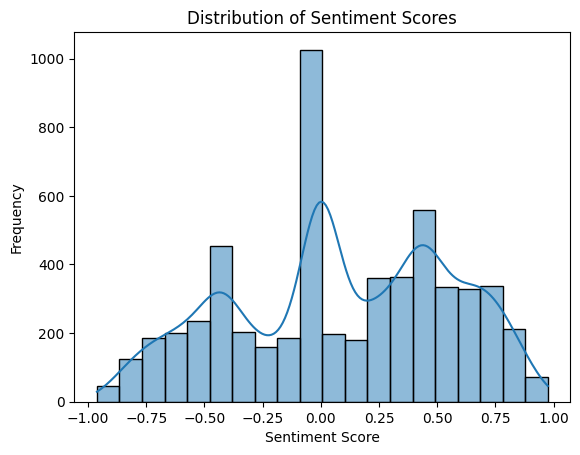

In [18]:
sns.histplot(data['sentiment_score'], bins=20, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

#### Sentiment Over Time

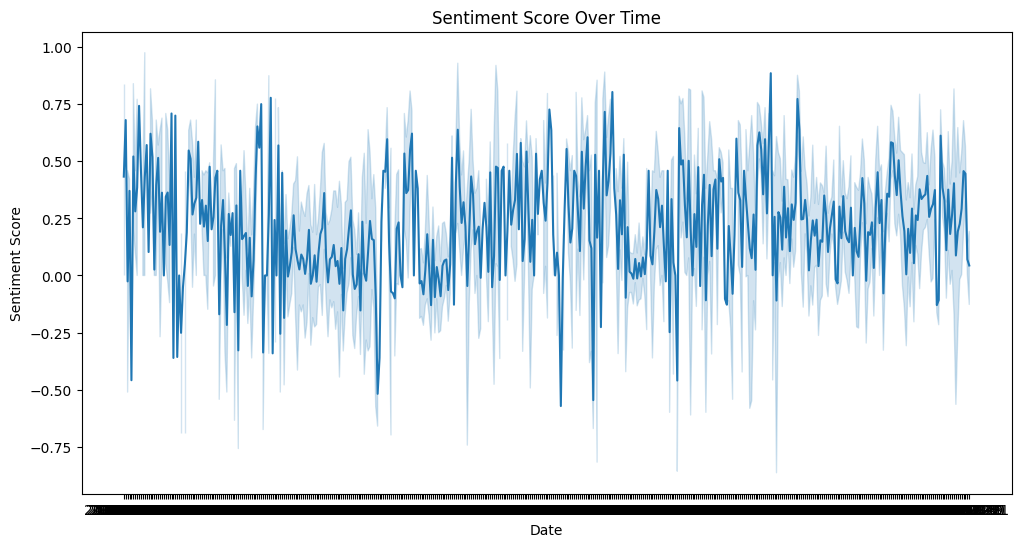

In [19]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='sentiment_score', data=data)
plt.title('Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()

#### Word Clouds

Positive Word Cloud


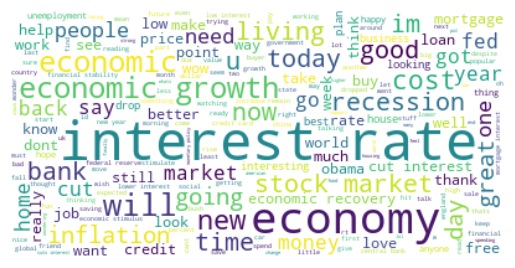

Negative Word Cloud


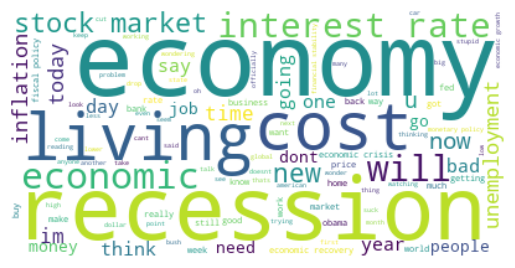

In [20]:
positiveTexts = data[data['sentiment_score'] > 0.1]
positiveString = ' '.join(positiveTexts['post'].tolist())
negativeTexts = data[data['sentiment_score'] < 0.1]
negativeString = ' '.join(negativeTexts['post'].tolist())

positiveWordCloud = WordCloud(background_color='white', max_words=200).generate(positiveString)
negativeWordCloud = WordCloud(background_color='white', max_words=200).generate(negativeString)

print("Positive Word Cloud")
plt.imshow(positiveWordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

print("Negative Word Cloud")
plt.imshow(negativeWordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Predictive Model

### Adjusting Dataset
This will add a "recession" column to the dataset with boolean valuse which will be true if the tweet was published during a period of recession, and false if it wasn't according to the timeline of the 2008 recession

In [24]:
if datasetName == "":
    collectionRef = fireDB.collection("processed_recession_data")

    batch = fireDB.batch()
    count = 0
    batch_size = 400

    dataframe_list = []

    startDate = pd.to_datetime('2007-12-01')
    endDate = pd.to_datetime('2009-01-01')

    docs = collectionRef.stream()
    
    for doc in docs:
        print("working")
        doc_dict = doc.to_dict()
        doc_date = pd.to_datetime(doc_dict.get('date', '1900-01-01')) 
        
        in_recession = startDate <= doc_date <= endDate
        
        doc_ref = collectionRef.document(doc.id)
       
        batch.update(doc_ref, {'recession': in_recession})
        
        doc_dict['recession'] = in_recession
        dataframe_list.append(doc_dict)
        
        count += 1
        
        if count >= batch_size:
            batch.commit()
            print(f"Batch of {count} documents committed.")
            batch = fireDB.batch()
            count = 0

    if count > 0:
        batch.commit()
        print(f"Final batch of {count} documents committed.")

    processedDF = pd.DataFrame(dataframe_list)

else: 
    processedDF = pd.read_csv(datasetPath)
    processedDF['date'] = pd.to_datetime(processedDF['date'])
    
    startDate = pd.to_datetime('2007-12-01')
    endDate = pd.to_datetime('2009-01-01')

    processedDF['recession'] = processedDF['date'].apply(lambda x: startDate <= x <= endDate)
    print(processedDF.head())

                                username  \
0                              Who Knows   
1                         Ye are many...   
2                     Petros Lafazanidis   
3                    A. Shankle-Knowlton   
4  John Kremer, Book Marketing Authority   

                                                post       date platform  \
0           sometimes the cost of living is too high 2007-01-11  Twitter   
1  in the end the interest rates where comparable... 2007-01-11  Twitter   
2  lopez doing it before the interest rates hit a... 2007-01-11  Twitter   
3  looking at credit unions interest rates 25 bas... 2007-01-18  Twitter   
4  whats in your wallet if youre with capital one... 2007-01-31  Twitter   

  language  sentiment_score  recession  
0       en           0.0000      False  
1       en           0.8402      False  
2       en           0.4588      False  
3       en           0.6808      False  
4       en          -0.5106      False  


### Training model for Predicting Recession

In [25]:
X = processedDF[['sentiment_score']] 
y = processedDF['recession']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

predictRecessionModel = RandomForestClassifier()
predictRecessionModel.fit(X_train, y_train)

predictions = predictRecessionModel.predict(X_test)
modelAccuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {modelAccuracy}")

Accuracy: 0.8932291666666666


### Function for Applying the Model

In [26]:
def calculateRecessionProbability(df, predictRecessionModel):
    X_new = df[['sentiment_score']]

    predictedRecession = predictRecessionModel.predict_proba(X_new)[:, 1]

    recessionProbability = np.mean(predictedRecession)
    
    return recessionProbability

### Model implementation

In [27]:
currentDirectory = os.getcwd()
testingDatasetPath = os.path.join(currentDirectory, 'testing_sentiment_analysis.xlsx')


new_data = pd.read_excel(testingDatasetPath) 

recessionProbability = calculateRecessionProbability(new_data, predictRecessionModel)

print("Overall probability of recession:", recessionProbability)


Overall probability of recession: 0.9231372642919381
